In [2]:
import numpy as np
import pandas as pd
import re
import wandb
import torch
import itertools
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, BertPreTrainedModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

In [4]:
wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)

data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


In [9]:
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = [2,2,2,2]

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, i) for i in self.num_labels])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        
        logits = [torch.sigmoid(logit) for logit in logits]
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:, i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss

            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

In [12]:
# Define compute metrics for evaluation
def compute_metrics_multi(p):
    logits = p.predictions # logits list<tensor(bs, num_label)> ~ list of batch prediction per class 
    label_batch = p.label_ids

    # print(p.predictions)
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = [torch.topk(torch.tensor(logit, dtype=torch.float), 1)[1] for logit in logits] # list<tensor(bs)>
    batch_size = label_batch.shape[0]
    num_label = len(hyp)
    for i in range(batch_size):
        hyps = []
        labels = torch.tensor(label_batch[i,:], dtype=torch.float)
        for j in range(num_label):
            hyps.append(hyp[j][i].item())

        hyps = torch.tensor(hyps, dtype=torch.float)
        list_hyp.append(hyps)
        list_label.append(labels)
    
    accuracy = accuracy_score(list_label, list_hyp)
    # print(accuracy)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(list_label, list_hyp, average='micro', zero_division=0)
    f1_macro = f1_score(list_label, list_hyp, average='macro', zero_division=0)

    # print(classification_report(list_label, list_hyp, zero_division=0, target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [13]:
# Define compute metrics for evaluation
def compute_metrics_single(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [20]:
def train_model(sequence_length, model_name, seed=42, multi_classifier=False, layers_freezed=6):
    if multi_classifier:
        config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
        config.num_labels = 4
        config.num_labels_list = [2,2,2,2]
        model = BertForMultiLabelClassification.from_pretrained(
            model_name,
            config=config
        )
        train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length, use_float=False)
        val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length, use_float=False)
    else:
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
        val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < layers_freezed:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue

    model.to(device)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results/netifier-passive',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_multi if multi_classifier else compute_metrics_single
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    eval_results = trainer.evaluate()
    
    print(eval_results)

# ABLATION: CLASSIFIER TYPE

In [17]:
train_model(128, 'indobenchmark/indobert-base-p1', multi_classifier=True)

Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifiers.0.bias', 'classifiers.0.weight', 'classifiers.1.bias', 'classifiers.1.weight', 'classifiers.2.bias', 'classifiers.2.weight', 'classifiers.3.bias', 'classifiers.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,1.688252,0.708039,0.779951,0.721719,0.749706,0.729169
2,1.795300,1.650742,0.708682,0.801047,0.692308,0.742718,0.734598
3,1.601700,1.620241,0.735048,0.783159,0.792609,0.787856,0.775630
4,1.516600,1.619463,0.732476,0.785174,0.782805,0.783988,0.770321
5,1.516600,1.610909,0.738907,0.770982,0.817496,0.793558,0.790683
6,1.454400,1.610939,0.726688,0.766335,0.813725,0.789320,0.785547
7,1.418100,1.605002,0.735691,0.795682,0.778281,0.786885,0.780578
8,1.384000,1.606041,0.737621,0.787155,0.794872,0.790994,0.785077
9,1.371700,1.604208,0.735691,0.796154,0.780543,0.788271,0.781361
10,1.371700,1.606190,0.732476,0.783905,0.793363,0.788606,0.782412


{'eval_loss': 1.61090886592865, 'eval_accuracy': 0.7389067524115756, 'eval_precision': 0.7709815078236131, 'eval_recall': 0.8174962292609351, 'eval_f1_micro': 0.7935578330893118, 'eval_f1_macro': 0.790683366269395, 'eval_runtime': 7.3802, 'eval_samples_per_second': 210.699, 'eval_steps_per_second': 13.279, 'epoch': 10.0}


In [18]:
train_model(128, 'indobenchmark/indobert-base-p1', multi_classifier=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.238067,0.707395,0.755427,0.787330,0.771049,0.761168
2,0.276500,0.224573,0.727974,0.776692,0.779035,0.777861,0.777041
3,0.177600,0.227681,0.735048,0.777616,0.806938,0.792006,0.785877
4,0.123100,0.265755,0.704823,0.749827,0.815988,0.781510,0.776815
5,0.123100,0.285083,0.731190,0.778024,0.795626,0.786726,0.783565
6,0.077300,0.334047,0.702251,0.733813,0.846154,0.785989,0.786090
7,0.048000,0.343496,0.729904,0.803543,0.752640,0.777259,0.771024
8,0.034400,0.360888,0.721543,0.764164,0.813725,0.788167,0.785740
9,0.024800,0.373670,0.720900,0.758741,0.818250,0.787373,0.784322
10,0.024800,0.365624,0.722186,0.773654,0.801659,0.787407,0.784818


{'eval_loss': 0.22768056392669678, 'eval_accuracy': 0.735048231511254, 'eval_precision': 0.7776162790697675, 'eval_recall': 0.8069381598793364, 'eval_f1_micro': 0.7920059215396003, 'eval_f1_macro': 0.7858773563449808, 'eval_runtime': 7.0962, 'eval_samples_per_second': 219.13, 'eval_steps_per_second': 13.81, 'epoch': 10.0}


# ABLATION - FREEZE LAYERS

## NO FREEZE

In [24]:
train_model(128, 'indobenchmark/indobert-base-p1', multi_classifier=False, layers_freezed=0) 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.221049,0.742122,0.782229,0.809955,0.795850,0.789748
2,0.262200,0.222378,0.733762,0.791125,0.779789,0.785416,0.782453
3,0.160400,0.240119,0.729260,0.772292,0.790347,0.781215,0.775450
4,0.095500,0.283501,0.733119,0.776462,0.791101,0.783713,0.775090
5,0.095500,0.307281,0.729260,0.793103,0.763198,0.777863,0.767594
6,0.049000,0.338608,0.734405,0.782738,0.793363,0.788015,0.780291
7,0.026500,0.375820,0.737621,0.805071,0.766214,0.785162,0.774832
8,0.016200,0.382492,0.736334,0.788490,0.795626,0.792042,0.784300
9,0.011800,0.397557,0.736334,0.779971,0.804676,0.792131,0.785286
10,0.011800,0.396310,0.737621,0.785240,0.802413,0.793734,0.786501


{'eval_loss': 0.22104939818382263, 'eval_accuracy': 0.7421221864951768, 'eval_precision': 0.7822286962855062, 'eval_recall': 0.8099547511312217, 'eval_f1_micro': 0.795850314931456, 'eval_f1_macro': 0.7897481934286074, 'eval_runtime': 7.0665, 'eval_samples_per_second': 220.052, 'eval_steps_per_second': 13.868, 'epoch': 10.0}


## 6 LAYERS

In [18]:
train_model(128, 'indobenchmark/indobert-base-p1', multi_classifier=False, layers_freezed=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.238067,0.707395,0.755427,0.787330,0.771049,0.761168
2,0.276500,0.224573,0.727974,0.776692,0.779035,0.777861,0.777041
3,0.177600,0.227681,0.735048,0.777616,0.806938,0.792006,0.785877
4,0.123100,0.265755,0.704823,0.749827,0.815988,0.781510,0.776815
5,0.123100,0.285083,0.731190,0.778024,0.795626,0.786726,0.783565
6,0.077300,0.334047,0.702251,0.733813,0.846154,0.785989,0.786090
7,0.048000,0.343496,0.729904,0.803543,0.752640,0.777259,0.771024
8,0.034400,0.360888,0.721543,0.764164,0.813725,0.788167,0.785740
9,0.024800,0.373670,0.720900,0.758741,0.818250,0.787373,0.784322
10,0.024800,0.365624,0.722186,0.773654,0.801659,0.787407,0.784818


{'eval_loss': 0.22768056392669678, 'eval_accuracy': 0.735048231511254, 'eval_precision': 0.7776162790697675, 'eval_recall': 0.8069381598793364, 'eval_f1_micro': 0.7920059215396003, 'eval_f1_macro': 0.7858773563449808, 'eval_runtime': 7.0962, 'eval_samples_per_second': 219.13, 'eval_steps_per_second': 13.81, 'epoch': 10.0}


## 8 LAYERS

In [21]:
train_model(128, 'indobenchmark/indobert-base-p1', multi_classifier=False, layers_freezed=8) 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.237551,0.707395,0.746971,0.790347,0.768047,0.758204
2,0.287100,0.221479,0.722830,0.786159,0.762443,0.774119,0.770915
3,0.191500,0.226884,0.724759,0.763571,0.806184,0.784299,0.777958
4,0.146300,0.243145,0.727331,0.773888,0.800151,0.786800,0.777241
5,0.146300,0.261850,0.726045,0.793292,0.766968,0.779908,0.769391
6,0.102800,0.290066,0.716399,0.745308,0.838612,0.789212,0.788240
7,0.074300,0.303172,0.729260,0.776878,0.795626,0.786140,0.777243
8,0.054000,0.329354,0.715113,0.745283,0.834087,0.787189,0.784116
9,0.044400,0.329205,0.732476,0.769615,0.813725,0.791056,0.786684
10,0.044400,0.329245,0.727974,0.777289,0.800151,0.788554,0.783284


{'eval_loss': 0.32920530438423157, 'eval_accuracy': 0.732475884244373, 'eval_precision': 0.7696148359486448, 'eval_recall': 0.8137254901960784, 'eval_f1_micro': 0.7910557184750733, 'eval_f1_macro': 0.7866838964570766, 'eval_runtime': 7.0993, 'eval_samples_per_second': 219.036, 'eval_steps_per_second': 13.804, 'epoch': 10.0}


## 10 LAYERS

In [22]:
train_model(128, 'indobenchmark/indobert-base-p1', multi_classifier=False, layers_freezed=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.253207,0.693248,0.725694,0.788084,0.755604,0.744882
2,0.308800,0.225946,0.718971,0.787081,0.744344,0.765116,0.759318
3,0.211000,0.225315,0.727331,0.777194,0.781297,0.779240,0.771995
4,0.172600,0.234999,0.720257,0.774049,0.782805,0.778403,0.764725
5,0.172600,0.245333,0.722186,0.782148,0.779789,0.780967,0.772097
6,0.136000,0.262774,0.714469,0.752078,0.819005,0.784116,0.778105
7,0.114400,0.276780,0.720257,0.757193,0.813725,0.784442,0.776171
8,0.091300,0.281559,0.722186,0.765973,0.804676,0.784847,0.776552
9,0.083600,0.288973,0.718971,0.768782,0.794872,0.781609,0.774309
10,0.083600,0.291407,0.722186,0.770408,0.797134,0.783543,0.776232


{'eval_loss': 0.2815586030483246, 'eval_accuracy': 0.7221864951768489, 'eval_precision': 0.7659727207465901, 'eval_recall': 0.8046757164404224, 'eval_f1_micro': 0.7848473703567488, 'eval_f1_macro': 0.7765521955817776, 'eval_runtime': 7.0937, 'eval_samples_per_second': 219.21, 'eval_steps_per_second': 13.815, 'epoch': 10.0}


## FULLY FREEZED

In [23]:
train_model(128, 'indobenchmark/indobert-base-p1', multi_classifier=False, layers_freezed=12)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.334860,0.593569,0.851711,0.337858,0.483801,0.414862
2,0.405500,0.283821,0.637942,0.783527,0.559578,0.652882,0.626020
3,0.286500,0.263543,0.656592,0.794589,0.598039,0.682444,0.657591
4,0.240700,0.252031,0.668167,0.769702,0.662896,0.712318,0.693835
5,0.240700,0.246598,0.680386,0.772414,0.675716,0.720837,0.707994
6,0.209200,0.243412,0.685531,0.764901,0.696833,0.729282,0.719849
7,0.188400,0.243103,0.688746,0.765957,0.705882,0.734694,0.723927
8,0.172700,0.243318,0.689389,0.776094,0.695324,0.733492,0.721430
9,0.168300,0.243300,0.688746,0.774874,0.693062,0.731688,0.720199
10,0.168300,0.243183,0.690032,0.772955,0.698341,0.733756,0.721618


{'eval_loss': 0.24310289323329926, 'eval_accuracy': 0.6887459807073955, 'eval_precision': 0.7659574468085106, 'eval_recall': 0.7058823529411765, 'eval_f1_micro': 0.7346938775510204, 'eval_f1_macro': 0.7239273274892924, 'eval_runtime': 7.0835, 'eval_samples_per_second': 219.524, 'eval_steps_per_second': 13.835, 'epoch': 10.0}


# ABLATION - SEQUENCE LENGTH

In [25]:
# Tokenize each text and calculate their lengths
token_lengths = [len(tokenizer.tokenize(text)) for text in X_train]

# Calculate the average length
average_length = sum(token_lengths) / len(token_lengths)
max_length = max(token_lengths)

print("Average length of tokenized text:", average_length)
print("Max token length:", max_length)

Average length of tokenized text: 54.3126407204889
Max token length: 2591


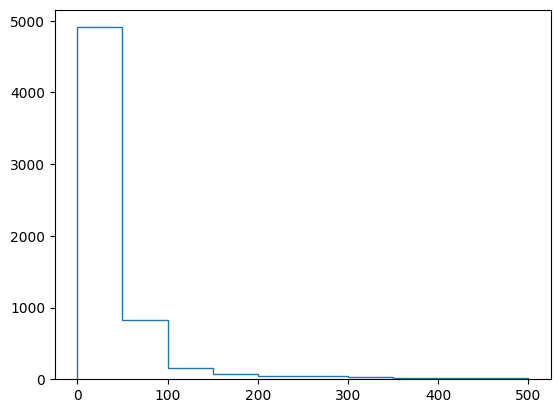

In [26]:
import matplotlib.pyplot as plt

counts, bins = np.histogram(token_lengths, range=(0, 500))
plt.stairs(counts, bins)
plt.show()

## MAX LENGTH 64

In [27]:
train_model(64, 'indobenchmark/indobert-base-p1')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.240055,0.716399,0.758496,0.791101,0.774456,0.766750
2,0.278300,0.223907,0.728617,0.800161,0.751885,0.775272,0.774416
3,0.183500,0.231723,0.729260,0.788863,0.769231,0.778923,0.774399
4,0.126300,0.263284,0.720257,0.787316,0.767722,0.777396,0.763792
5,0.126300,0.288229,0.719614,0.778029,0.779789,0.778908,0.774926
6,0.077900,0.318748,0.723473,0.756401,0.824284,0.788885,0.787536
7,0.050700,0.339900,0.725402,0.791667,0.759427,0.775212,0.769270
8,0.035000,0.359005,0.720900,0.761973,0.803922,0.782385,0.779991
9,0.025300,0.368483,0.726688,0.765299,0.801659,0.783057,0.780856
10,0.025300,0.369731,0.731190,0.776627,0.791855,0.784167,0.780261


{'eval_loss': 0.31874769926071167, 'eval_accuracy': 0.7234726688102894, 'eval_precision': 0.756401384083045, 'eval_recall': 0.8242835595776772, 'eval_f1_micro': 0.7888848791050163, 'eval_f1_macro': 0.7875355390047298, 'eval_runtime': 4.8342, 'eval_samples_per_second': 321.664, 'eval_steps_per_second': 20.272, 'epoch': 10.0}


## MAX LENGTH 80

In [28]:
train_model(80, 'indobenchmark/indobert-base-p1')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.233324,0.716399,0.765351,0.789593,0.777283,0.766951
2,0.275500,0.219845,0.737621,0.803318,0.766968,0.784722,0.782234
3,0.181300,0.229127,0.729904,0.777372,0.803167,0.790059,0.783199
4,0.124500,0.254633,0.732476,0.798905,0.769985,0.784178,0.774412
5,0.124500,0.298243,0.724116,0.756757,0.823529,0.788732,0.785397
6,0.077600,0.318122,0.709325,0.746441,0.830317,0.786148,0.785643
7,0.048300,0.339112,0.727974,0.784627,0.777526,0.781061,0.778147
8,0.034100,0.358802,0.727974,0.768625,0.809201,0.788391,0.785610
9,0.024600,0.370270,0.728617,0.775165,0.795626,0.785262,0.783404
10,0.024600,0.370343,0.724759,0.775585,0.800151,0.787676,0.785657


{'eval_loss': 0.22912734746932983, 'eval_accuracy': 0.729903536977492, 'eval_precision': 0.7773722627737226, 'eval_recall': 0.8031674208144797, 'eval_f1_micro': 0.7900593471810089, 'eval_f1_macro': 0.7831989229453638, 'eval_runtime': 5.691, 'eval_samples_per_second': 273.239, 'eval_steps_per_second': 17.22, 'epoch': 10.0}


## MAX LENGTH 96

In [29]:
train_model(96, 'indobenchmark/indobert-base-p1')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.234395,0.712540,0.770504,0.772247,0.771375,0.761716
2,0.274800,0.222820,0.727331,0.803265,0.742081,0.771462,0.771459
3,0.180400,0.243920,0.727974,0.749498,0.843891,0.793899,0.787779
4,0.123600,0.262640,0.726045,0.779018,0.789593,0.784270,0.777756
5,0.123600,0.285395,0.721543,0.764037,0.810709,0.786681,0.784140
6,0.077000,0.311835,0.717685,0.748660,0.842383,0.792761,0.791125
7,0.050600,0.332521,0.724116,0.786423,0.777526,0.781949,0.775178
8,0.034100,0.365140,0.722830,0.759831,0.815988,0.786909,0.781479
9,0.024800,0.365213,0.726045,0.767408,0.806184,0.786318,0.780833
10,0.024800,0.362444,0.728617,0.774333,0.809955,0.791743,0.787563


{'eval_loss': 0.24392013251781464, 'eval_accuracy': 0.7279742765273312, 'eval_precision': 0.7494976557267247, 'eval_recall': 0.8438914027149321, 'eval_f1_micro': 0.7938985455835403, 'eval_f1_macro': 0.7877792928590184, 'eval_runtime': 6.1953, 'eval_samples_per_second': 250.998, 'eval_steps_per_second': 15.819, 'epoch': 10.0}


# USE BEST CONFIG

In [30]:
seeds = [50, 81, 14, 3, 94]

for seed in seeds:
    set_seed(seed)
    print("SEED:", seed)
    train_model(128, 'indobenchmark/indobert-base-p1', seed=seed)

SEED: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.238083,0.711897,0.741781,0.816742,0.777459,0.765445
2,0.278700,0.219809,0.734405,0.799686,0.767722,0.783378,0.773880
3,0.187100,0.225664,0.725402,0.771631,0.820513,0.795322,0.793131
4,0.125600,0.250566,0.720900,0.766901,0.821267,0.793154,0.789530
5,0.125600,0.279562,0.736977,0.791957,0.772247,0.781978,0.772902
6,0.080200,0.309178,0.734405,0.804452,0.763198,0.783282,0.778211
7,0.054000,0.337428,0.720257,0.774403,0.807692,0.790698,0.786729
8,0.034500,0.339876,0.729260,0.782609,0.800905,0.791651,0.784861
9,0.026500,0.352955,0.725402,0.779749,0.795626,0.787607,0.780295
10,0.026500,0.359670,0.728617,0.779810,0.803922,0.791682,0.783786


{'eval_loss': 0.22566385567188263, 'eval_accuracy': 0.7254019292604501, 'eval_precision': 0.7716312056737589, 'eval_recall': 0.8205128205128205, 'eval_f1_micro': 0.7953216374269005, 'eval_f1_macro': 0.7931312336327655, 'eval_runtime': 7.2443, 'eval_samples_per_second': 214.652, 'eval_steps_per_second': 13.528, 'epoch': 10.0}
SEED: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.238776,0.711897,0.729858,0.812971,0.769176,0.766905
2,0.275600,0.218179,0.736977,0.785660,0.785068,0.785364,0.778489
3,0.179900,0.237848,0.723473,0.790143,0.749623,0.769350,0.765831
4,0.127700,0.259613,0.720257,0.761905,0.808446,0.784486,0.778934
5,0.127700,0.279223,0.732476,0.810723,0.752640,0.780602,0.768570
6,0.079100,0.300779,0.738907,0.789866,0.799397,0.794603,0.787617
7,0.050500,0.342165,0.721543,0.755158,0.828054,0.789928,0.787337
8,0.034700,0.353084,0.726688,0.772727,0.807692,0.789823,0.786193
9,0.024500,0.363216,0.720900,0.768053,0.794118,0.780868,0.772785
10,0.024500,0.363246,0.722830,0.769231,0.799397,0.784024,0.777768


{'eval_loss': 0.3007791042327881, 'eval_accuracy': 0.7389067524115756, 'eval_precision': 0.789865871833085, 'eval_recall': 0.799396681749623, 'eval_f1_micro': 0.7946026986506748, 'eval_f1_macro': 0.7876170210635971, 'eval_runtime': 7.0567, 'eval_samples_per_second': 220.359, 'eval_steps_per_second': 13.888, 'epoch': 10.0}
SEED: 14


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.237338,0.702251,0.744286,0.785822,0.764490,0.754919
2,0.275300,0.219795,0.724759,0.778111,0.782805,0.780451,0.775790
3,0.184900,0.231293,0.722186,0.763326,0.809955,0.785950,0.778471
4,0.125000,0.256614,0.739550,0.790396,0.782051,0.786202,0.779264
5,0.125000,0.302691,0.715756,0.742088,0.831071,0.784063,0.780814
6,0.076800,0.314455,0.726688,0.784627,0.777526,0.781061,0.773463
7,0.047900,0.334512,0.720900,0.786482,0.772247,0.779300,0.773620
8,0.036000,0.366639,0.722830,0.776108,0.779035,0.777569,0.771326
9,0.024400,0.377470,0.720900,0.757597,0.808446,0.782196,0.775919
10,0.024400,0.375527,0.721543,0.763043,0.794118,0.778271,0.771974


{'eval_loss': 0.2566143870353699, 'eval_accuracy': 0.7395498392282959, 'eval_precision': 0.7903963414634146, 'eval_recall': 0.782051282051282, 'eval_f1_micro': 0.7862016679302501, 'eval_f1_macro': 0.7792638269925131, 'eval_runtime': 7.146, 'eval_samples_per_second': 217.603, 'eval_steps_per_second': 13.714, 'epoch': 10.0}
SEED: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.233712,0.705466,0.791632,0.713424,0.750496,0.740545
2,0.280200,0.219278,0.726688,0.798737,0.763198,0.780563,0.773438
3,0.180500,0.229409,0.731833,0.779661,0.797888,0.788669,0.783346
4,0.131000,0.259881,0.726045,0.799358,0.751131,0.774495,0.765872
5,0.131000,0.298851,0.713183,0.746086,0.826546,0.784258,0.783003
6,0.081200,0.323375,0.724116,0.749831,0.836350,0.790731,0.787797
7,0.052900,0.342007,0.717685,0.773543,0.780543,0.777027,0.771636
8,0.036300,0.368793,0.720900,0.767611,0.797134,0.782094,0.777438
9,0.026700,0.378145,0.720900,0.769565,0.800905,0.784922,0.781253
10,0.026700,0.379450,0.720257,0.775298,0.785822,0.780524,0.775717


{'eval_loss': 0.3233751952648163, 'eval_accuracy': 0.7241157556270097, 'eval_precision': 0.7498309668695065, 'eval_recall': 0.8363499245852187, 'eval_f1_micro': 0.7907308377896612, 'eval_f1_macro': 0.7877973488660139, 'eval_runtime': 7.1825, 'eval_samples_per_second': 216.497, 'eval_steps_per_second': 13.644, 'epoch': 10.0}
SEED: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241316,0.691318,0.831028,0.634238,0.719418,0.689379
2,0.278500,0.219678,0.716399,0.774313,0.786576,0.780397,0.771237
3,0.183500,0.224486,0.734405,0.788129,0.791101,0.789612,0.787975
4,0.128200,0.258995,0.726045,0.799681,0.755656,0.777045,0.769373
5,0.128200,0.282576,0.722830,0.785011,0.782051,0.783529,0.779032
6,0.081300,0.305507,0.729904,0.784592,0.791101,0.787833,0.782683
7,0.051700,0.334984,0.720900,0.761636,0.814480,0.787172,0.783743
8,0.036800,0.351632,0.724116,0.761636,0.814480,0.787172,0.782429
9,0.025500,0.348661,0.726688,0.782934,0.788839,0.785875,0.782576
10,0.025500,0.360749,0.726688,0.775182,0.800905,0.787834,0.783174


{'eval_loss': 0.22448624670505524, 'eval_accuracy': 0.7344051446945338, 'eval_precision': 0.7881292261457551, 'eval_recall': 0.7911010558069381, 'eval_f1_micro': 0.7896123447497179, 'eval_f1_macro': 0.7879748706770465, 'eval_runtime': 7.1103, 'eval_samples_per_second': 218.696, 'eval_steps_per_second': 13.783, 'epoch': 10.0}
